## Coding the transformer block

### To end flow

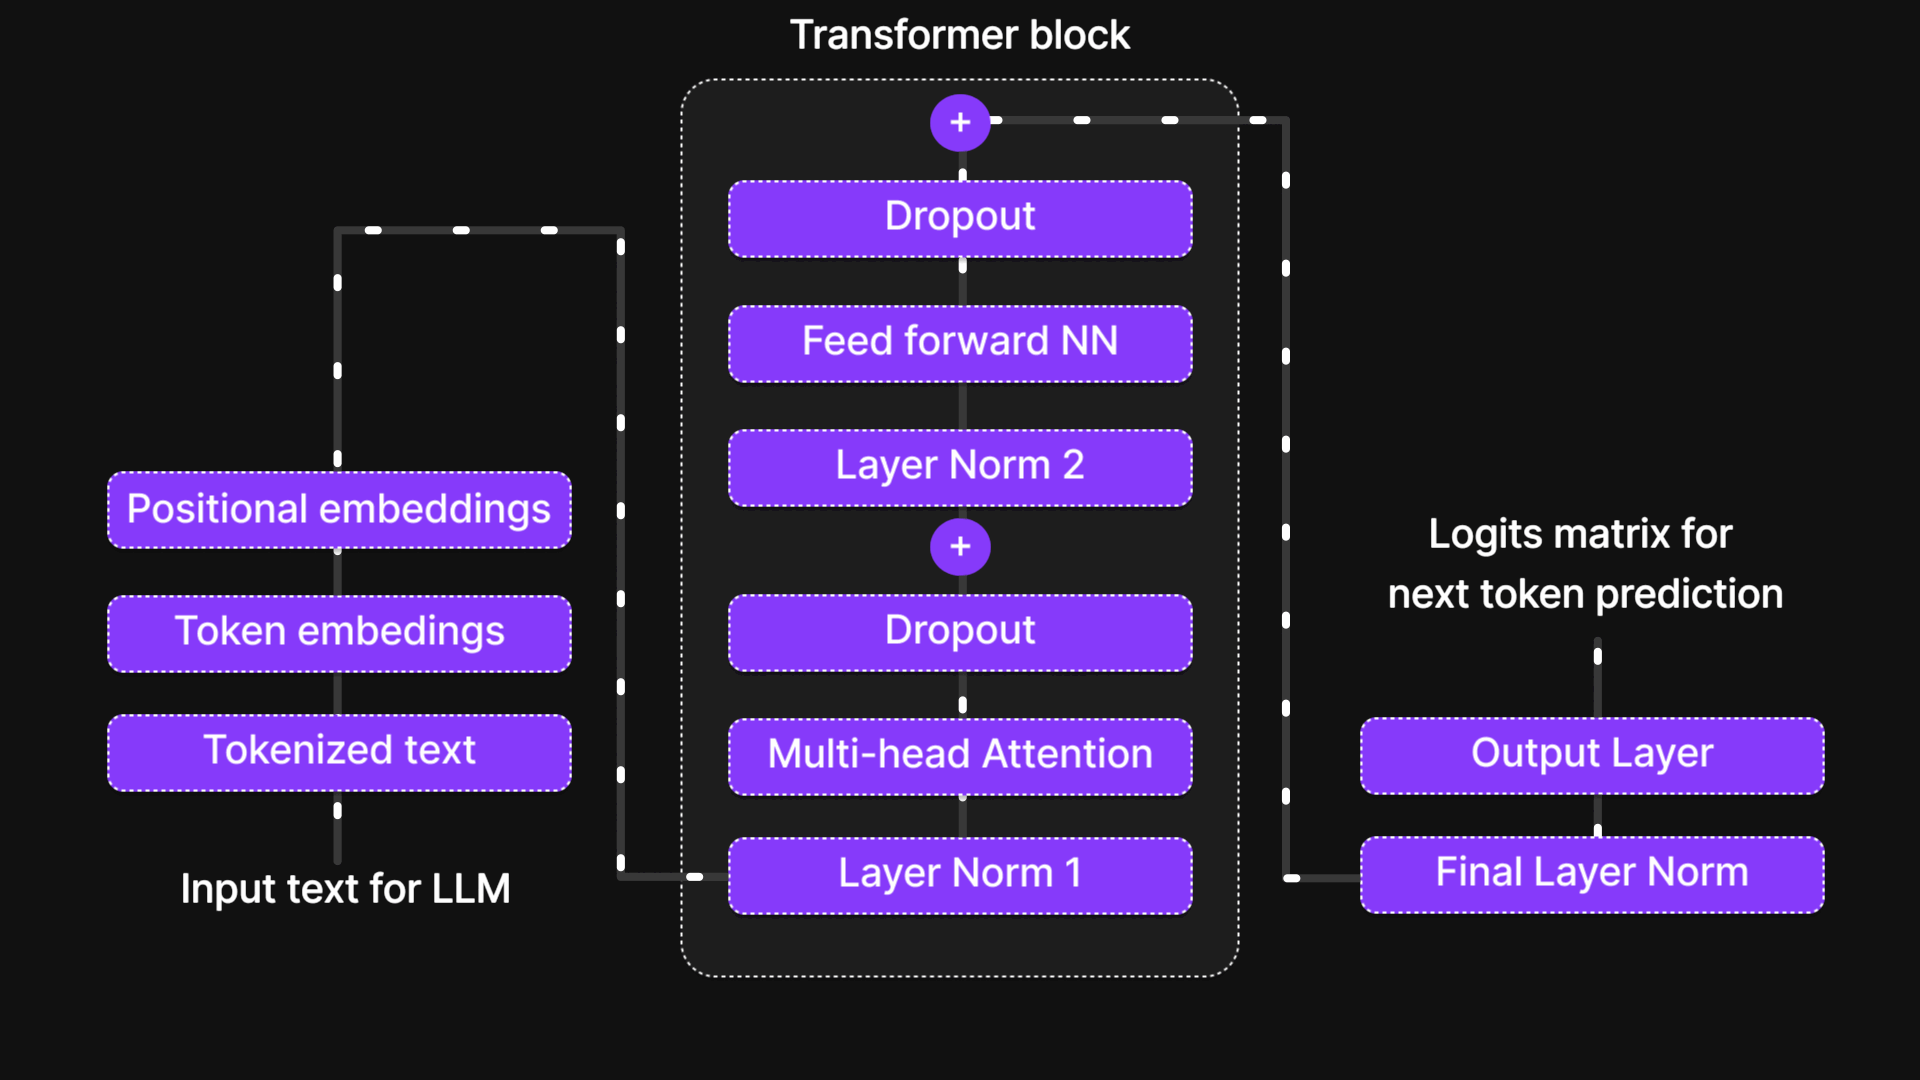

In [1]:
from IPython.display import Image
Image(filename='transformerblock.gif')

## GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

<div class="alert alert-block alert-success">

Let's take a relook at the transformer block

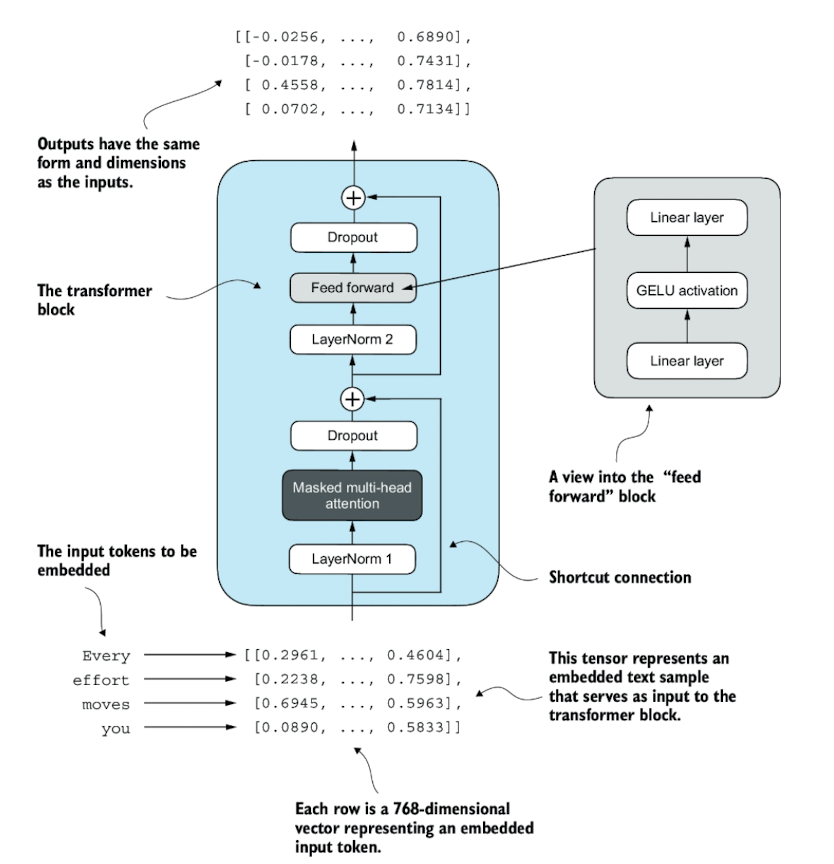

</div>

<div class="alert alert-block alert-success">
Let us code a transformer block as follows:
</div>

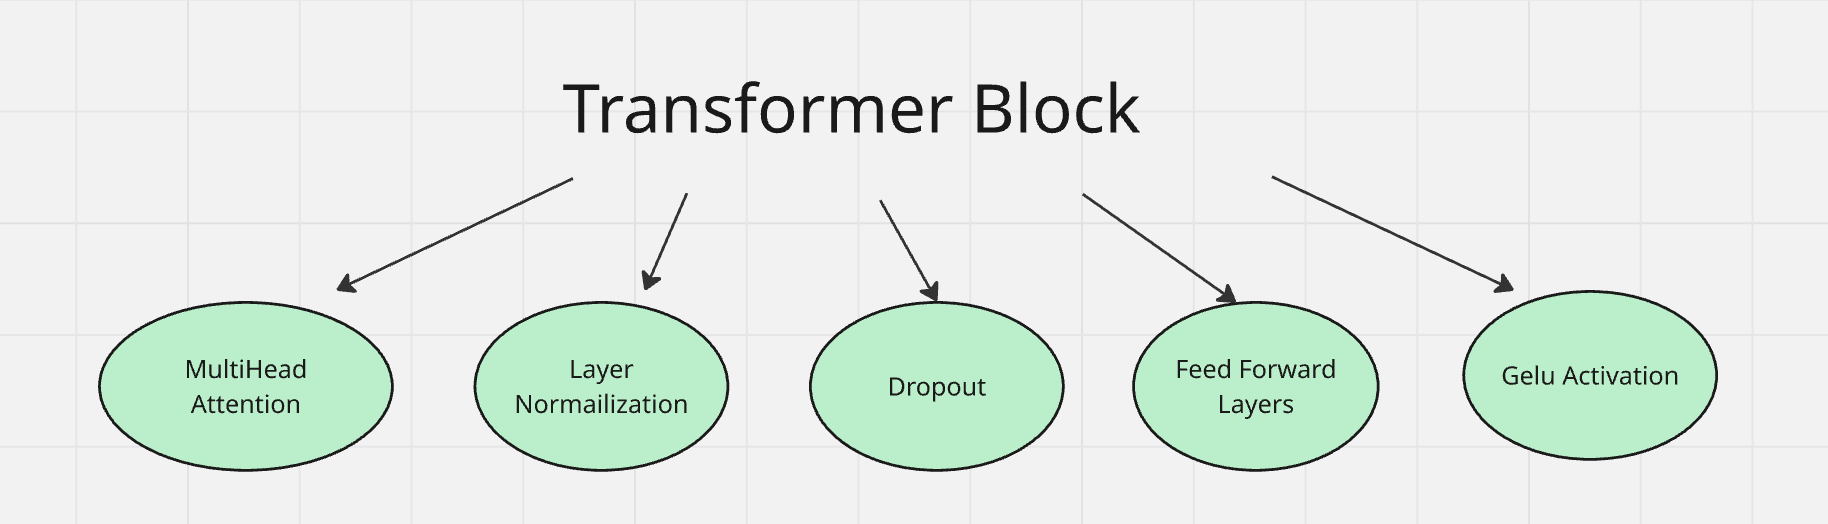

<div class="alert alert-block alert-info">

### Multihead Attention

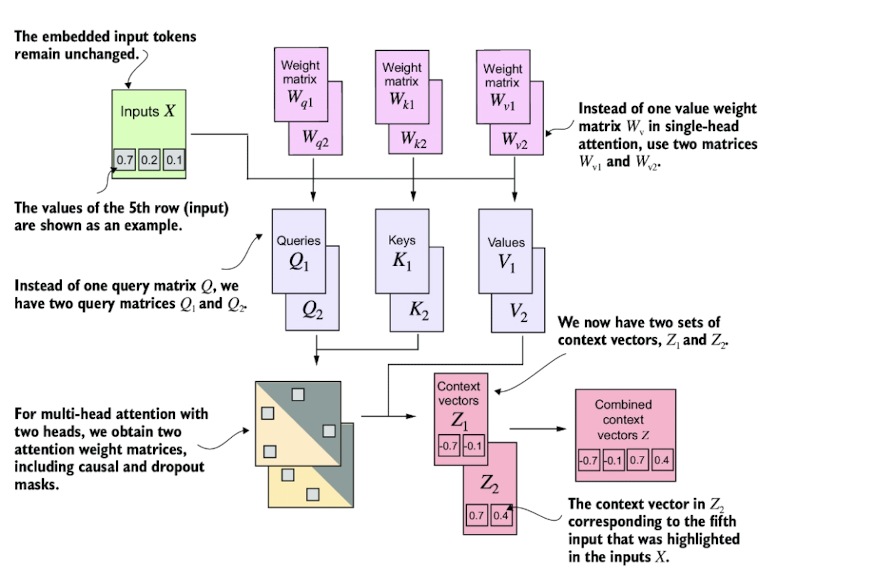


<b>After Optimization:</b>

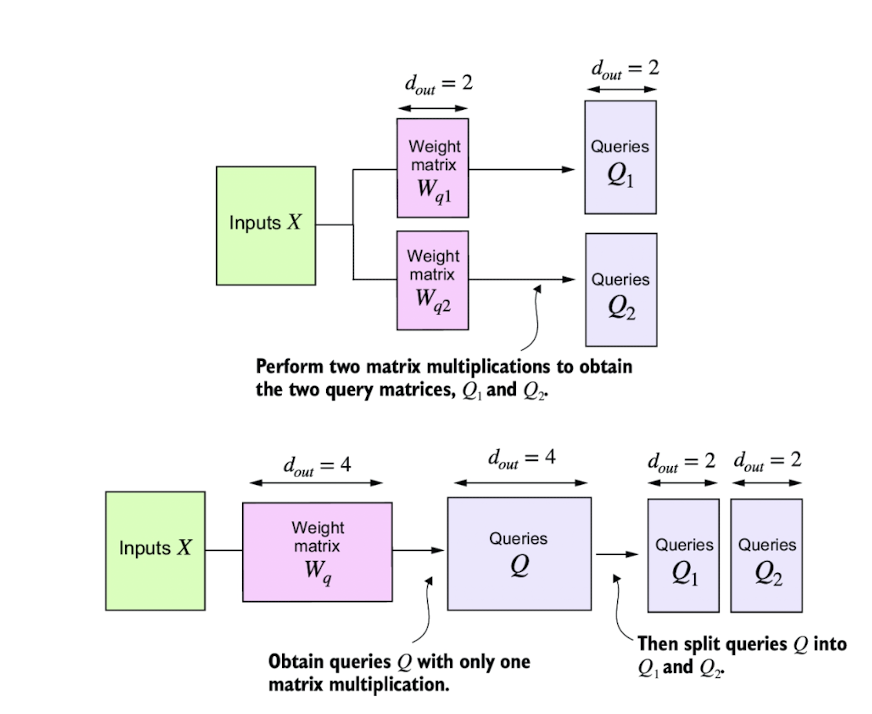

</div>

<div class="alert alert-block alert-info">

Step 1: Shortcut connection for attention block

Step 2:  Shortcut connection for feed forward block

Step 3: Add the original input back
</div>

In [2]:
import torch
import torch.nn as nn

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size - tiktoken bpe
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

<div class="alert alert-block alert-info">
    
### Layer Normalization

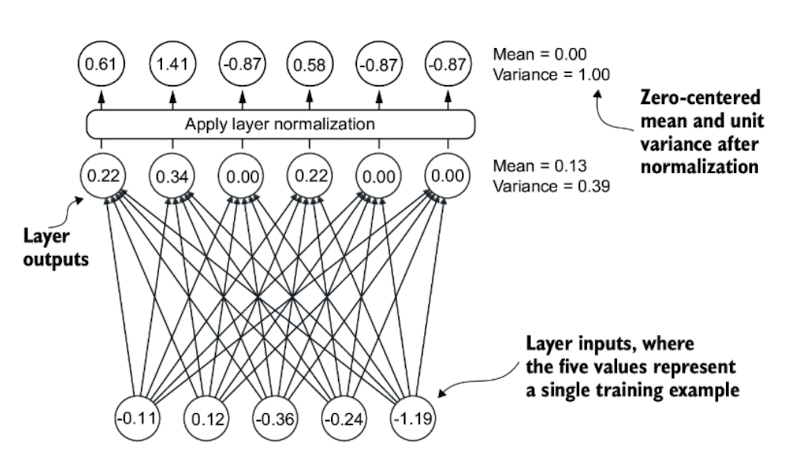

An illustration of layer normalization where the six outputs of the layer, also called activations, are normalized such that they have a 0 mean and a variance of 1. 

In normalization what is done is that we look at individual rows and then we normalize across the columns so we make sure that let's say the mean is zero and the standard deviation is one

</div>

<div class="alert alert-block alert-info">
    
### Dropout

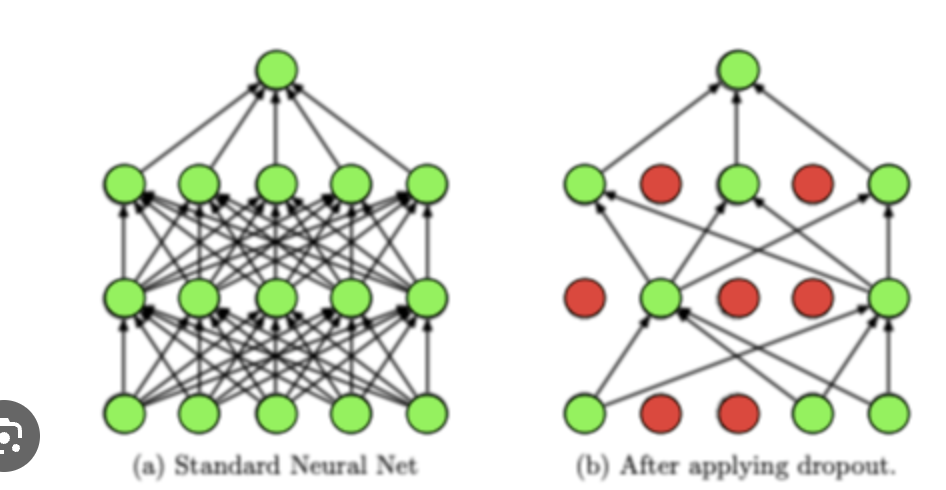

</div>

In [4]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

<div class="alert alert-block alert-info">
   
### Feedforward and Gelu

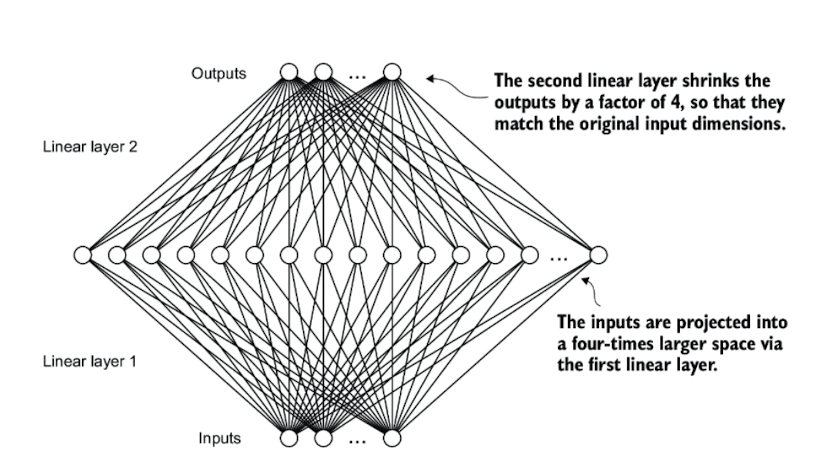

An illustration of the expansion and contraction of the layer outputs in the feed forward neural network. First, the inputs expand by a factor of 4 from 768 to 3,072 values. Then, the second layer compresses the 3,072 values back into a 768-dimensional representation.


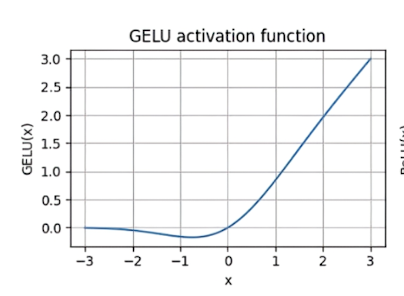

Gelu handles the -ve value cases preventing dead neuron problem 

<b>

w = w - $\alpha$ * $\frac{\partial L}{\partial w}$

</b>

</div>

<div class="alert alert-block alert-info">

### Shortcut Connections

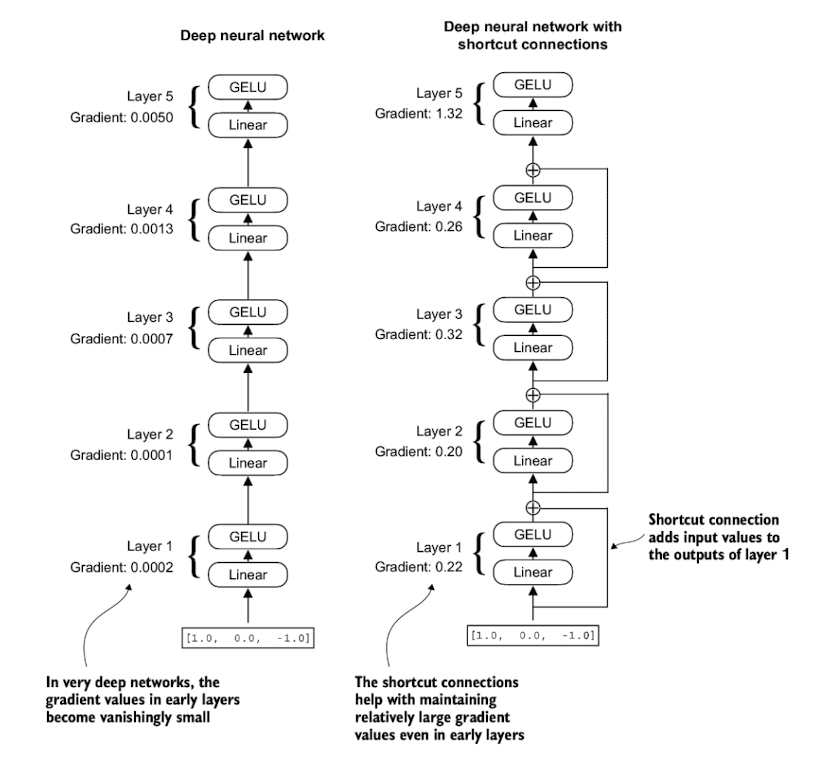

A comparison between a deep neural network consisting of five layers without (left) and with shortcut connections (right). Shortcut connections

In [5]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [6]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

<div class="alert alert-block alert-success">

## Transformer block Shape Preservation

Preserving the shape within a Transformer block is crucial for understanding its function. When a Transformer block processes an input sequence, each element is represented by a vector of fixed size, known as the embedding dimension. It's important to highlight that the operations within the Transformer block, like multi-head attention and feed-forward layers, are designed to transform these input vectors while maintaining their dimensionality. This preservation of dimensionality is key. Observing a Transformer block, you'll notice that the input and output share the same form and dimensions. This characteristic is what allows multiple Transformer blocks to be easily stacked, as seen in models like GPT-2, which consists of 12 Transformer blocks. The ease of stacking is due to the fact that the dimensionality of the input to a Transformer block is the same as the dimensionality of its output.

The embedding dimension for GPT-2 = 768 (din) </br>
Output Generated Context will also have to be same size = 768 (dout) </br>

For GPT-2 we use 12 heads, context length = 1024  </br>

Hence sizes of WQ, WK,WV matrix will be (din x dout) -> (768 x 768)  </br>
Input will be (b, context_len, din) -> (b, 1024, 768) </br>

Q , K , V  will be -> (b, 1024, 768) </br>

After Split for 12 heads each Q, K and V will be (1024 x 64) , there will be 12 such Q , K and V matrices </br>

There will be 12 Attention matrices - Q*Kt -> (1024 x 1024) (Since [1024 x 64] x [64 x 1024])  </br>

And finally there will be 12 context matrices due to Attention*V -> [1024 x 1024] x [1024 x64] -> (1024 x64) </br>

These will be stacked along the column to give you (1024 x (64 x12)) => (1024 x 768) </br>


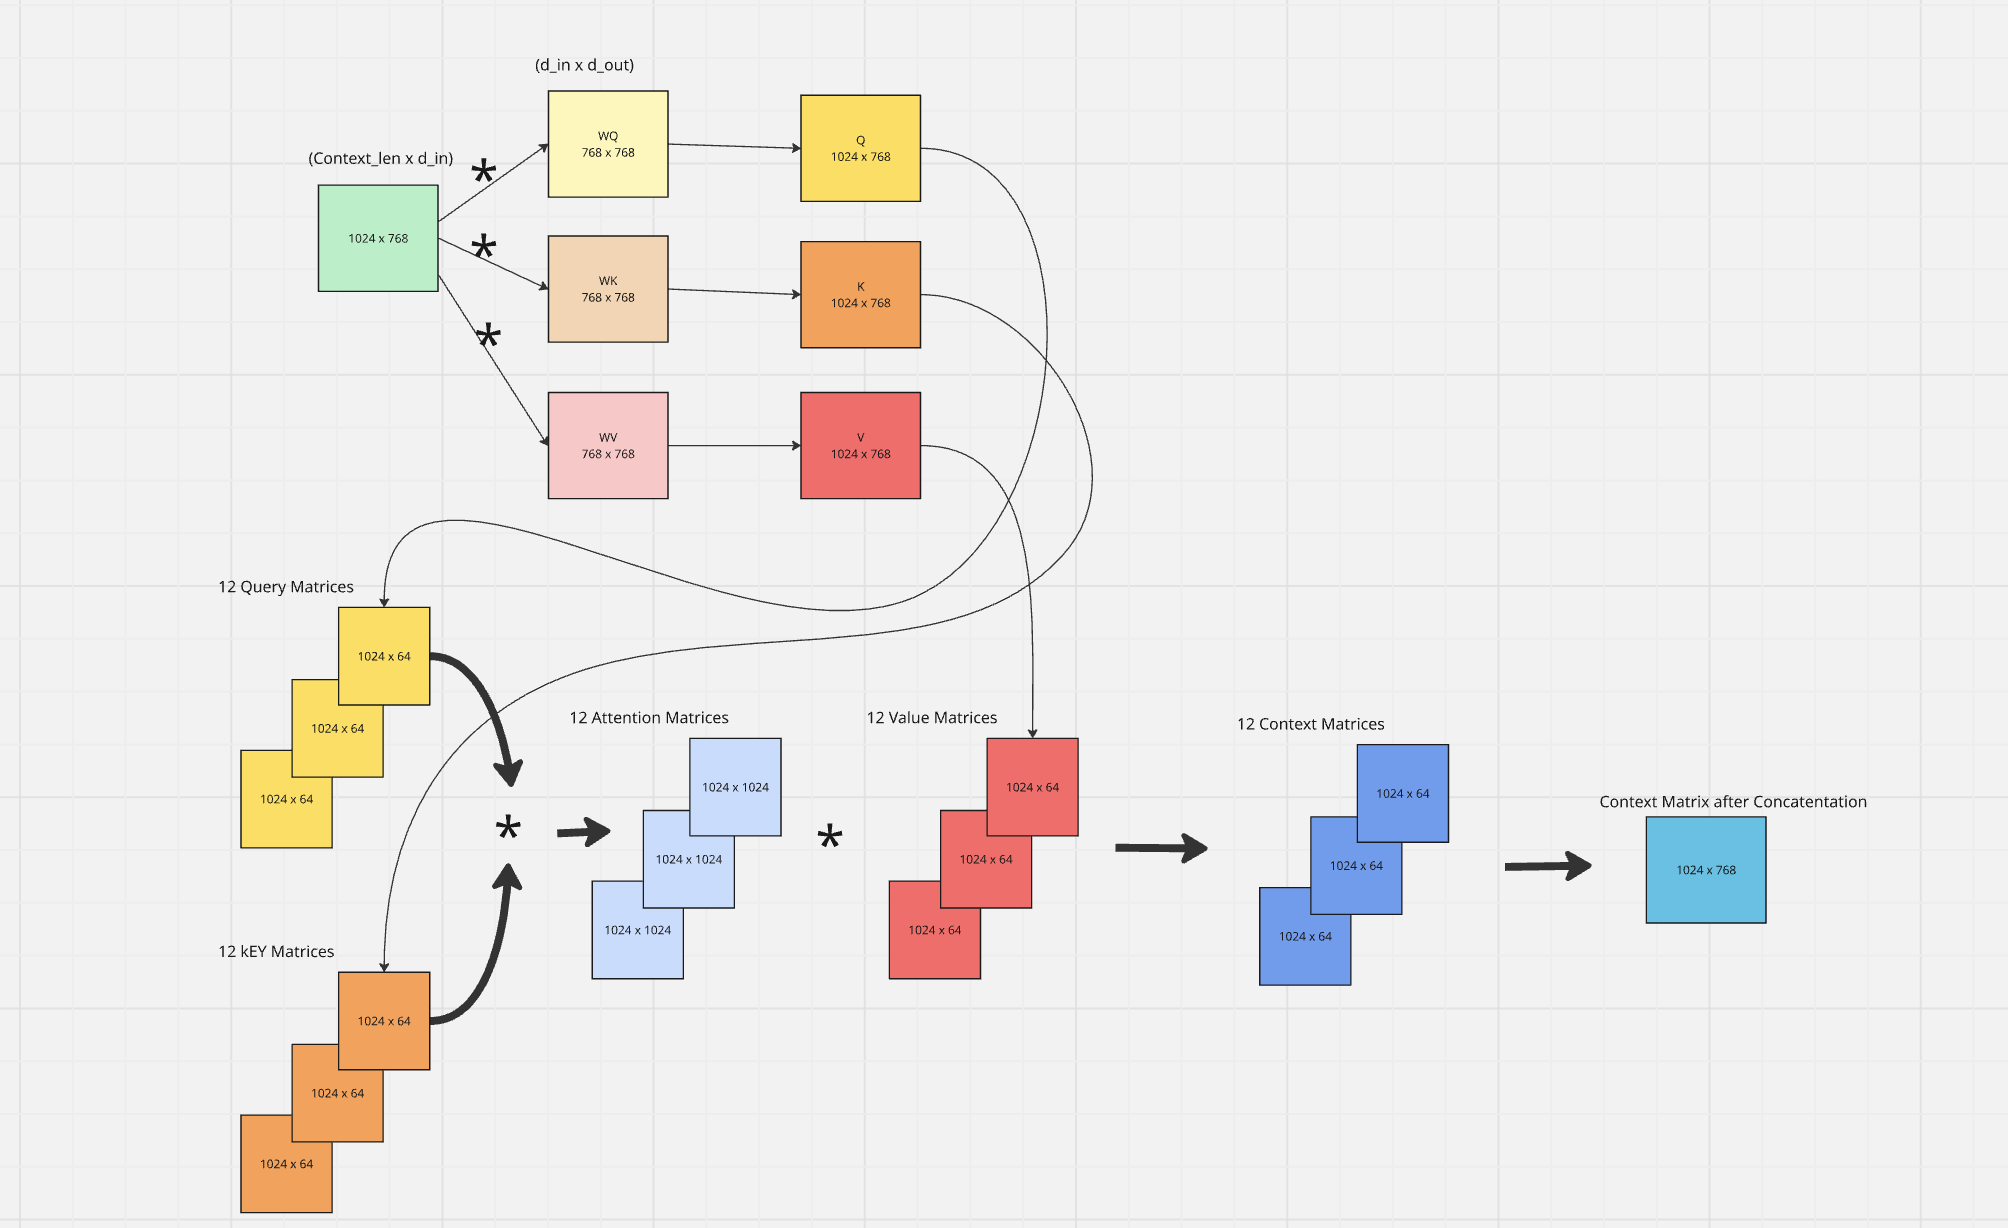


This helps scale the transformer.

</div>

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size] #RETURNS CONTEXT
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

<div class="alert alert-block alert-warning">

The given code defines a TransformerBlock class in PyTorch that includes a multi-head
attention mechanism (MultiHeadAttention) and a feed forward network (FeedForward),
both configured based on a provided configuration dictionary (cfg), such as
GPT_CONFIG_124M
</div>

<div class="alert alert-block alert-warning">

Layer normalization (LayerNorm) is applied before each of these two components, and
dropout is applied after them to regularize the model and prevent overfitting. 

This is also known as Pre-LayerNorm. 

Older architectures, such as the original transformer model,
applied layer normalization after the self-attention and feed-forward networks instead,
known as Post-LayerNorm, which often leads to worse training dynamics.
</div>

<div class="alert alert-block alert-warning">

The class also implements the forward pass, where each component is followed by a
shortcut connection that adds the input of the block to its output. This critical feature helps
gradients flow through the network during training and improves the learning of deep
models 
</div>

<div class="alert alert-block alert-success">
Using the GPT_CONFIG_124M dictionary we defined earlier, let's instantiate a transformer
block and feed it some sample data
</div>

<div class="alert alert-block alert-info">

Create sample input of shape [batch_size, num_tokens, emb_dim]
</div>

In [8]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<div class="alert alert-block alert-info">

As we can see from the code output, the transformer block maintains the input dimensions
in its output, indicating that the transformer architecture processes sequences of data
without altering their shape throughout the network.
</div>

<div class="alert alert-block alert-warning">
    
The preservation of shape throughout the transformer block architecture is not incidental
but a crucial aspect of its design. 

This design enables its effective application across a wide
range of sequence-to-sequence tasks, where each output vector directly corresponds to an
input vector, maintaining a one-to-one relationship. 
</div>

<div class="alert alert-block alert-warning">

However, the output is a context vector
that encapsulates information from the entire input sequence.

This means that while the physical dimensions of the sequence (length and feature size)
remain unchanged as it passes through the transformer block, the content of each output
vector is re-encoded to integrate contextual information from across the entire input
sequence.

</div>

## What we have learned 

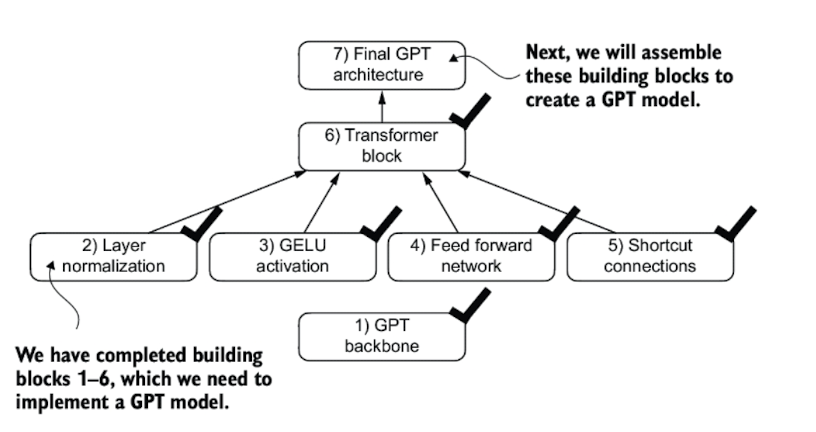
